# Link Plots to Features

`Rubicon_ml` makes it easy to log plots with features and artifacts. In this example we'll walk through creating a feature dependency plot using the `shap` package and saving it to an artifact.

Before getting started, we'll have to install some dependencies for this example.

In [1]:
! pip install matplotlib kaleido Pillow shap "numba>=0.56.2"

## Set up
First lets create a Rubicon `project` and create a pipeline with `rubicon_ml.sklearn.pipeline`.

In [2]:
import shap
import sklearn
from sklearn.datasets import load_wine
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

from rubicon_ml import Rubicon
from rubicon_ml.sklearn import make_pipeline


rubicon = Rubicon(persistence="memory")
project = rubicon.get_or_create_project("Logging Feature Plots")

X, y = load_wine(return_X_y=True)

reg = GradientBoostingRegressor(random_state=1)
pipeline = make_pipeline(project, reg)

pipeline.fit(X, y)

RubiconPipeline(project=<rubicon_ml.client.project.Project object at 0x167a37c40>,
                steps=[('gradientboostingregressor',
                        GradientBoostingRegressor(random_state=1))])

## Generating Data
After fitting the pipeline, using `shap.Explainer` we can generate `shap` values to later plot. For more information on generating `shap` values with `shap.explainer`, check the documentation [here](https://shap.readthedocs.io/en/latest/generated/shap.Explainer.html).

In [3]:
explainer = shap.Explainer(pipeline[0])
shap_values = explainer.shap_values(X)

## Plotting

The generated `shap_values` from the above cell can be passed to a `shap.depence_plot` to generate a dependence plot. `pl.gcf()` allows the plot generated by `shap` to be saved to a variable. Using the `matplotlib` and  `io` libraries, shap plots can be saved to a `byte` representation. Here, a feature and its plot are both logged with`rubicon_ml.Features` and `rubuicon_ml.Artifact` respectively. These `features` and `artifacts` are logged to the same `rubicon_ml.Experiment` that was created by calling `pipeline.fit`.

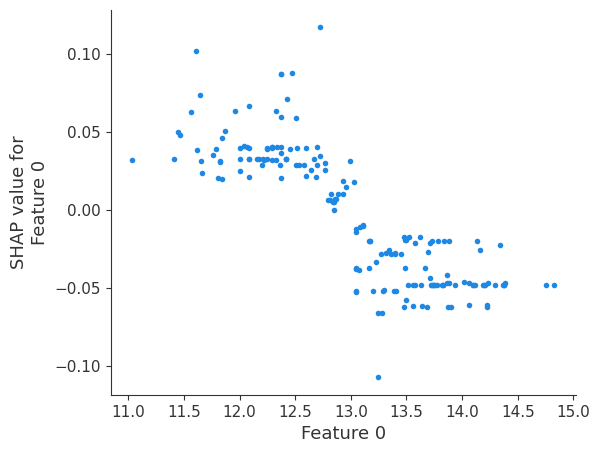

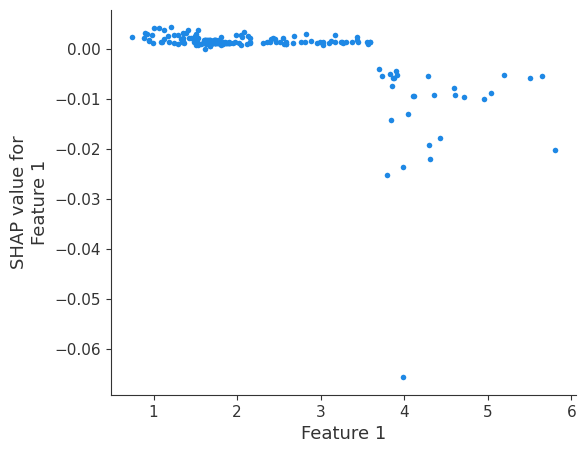

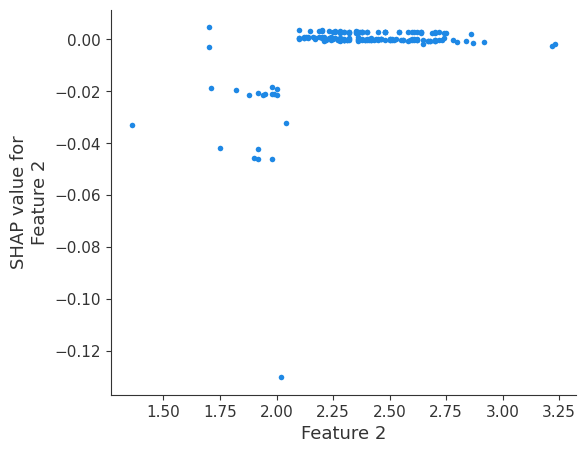

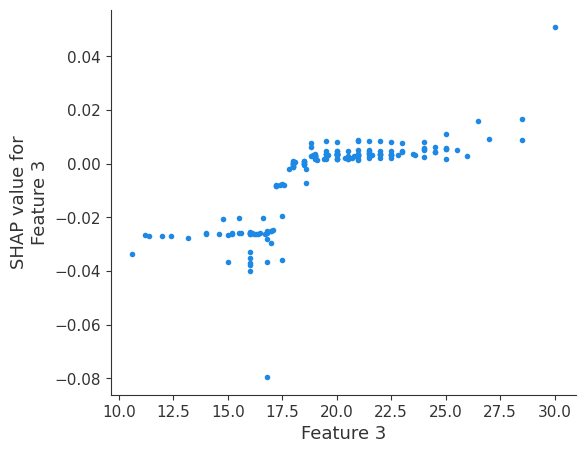

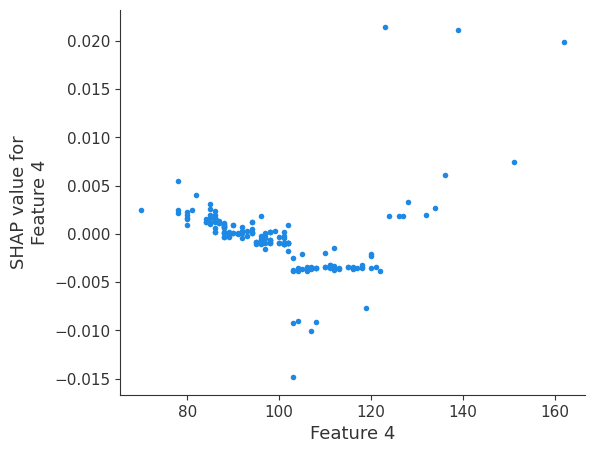

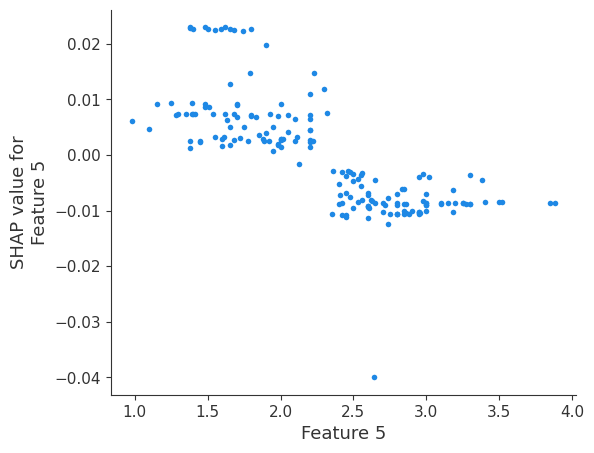

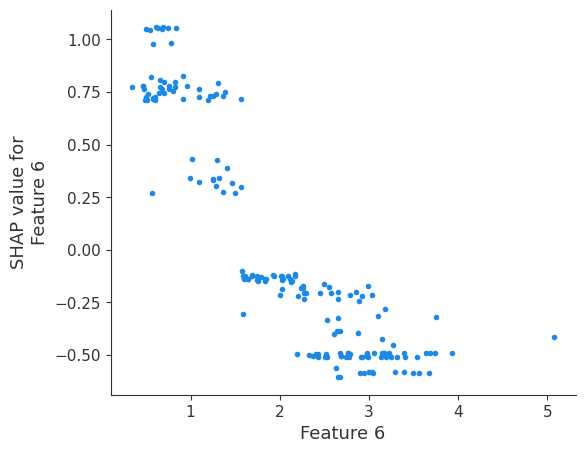

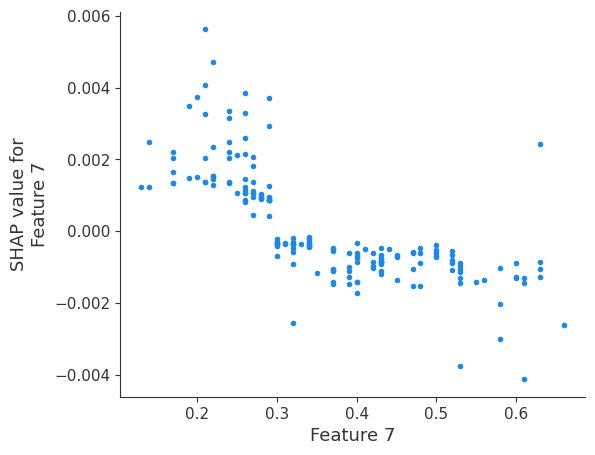

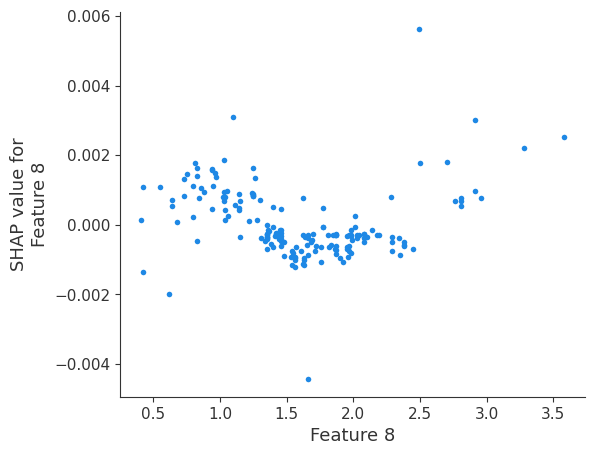

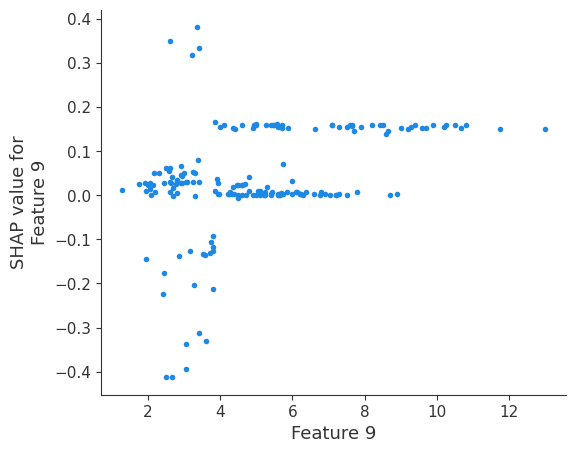

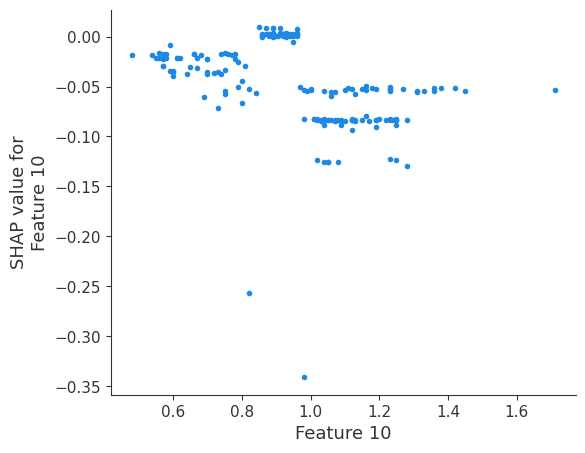

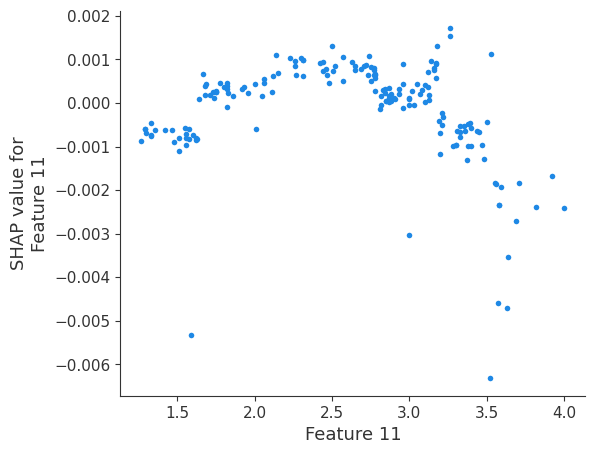

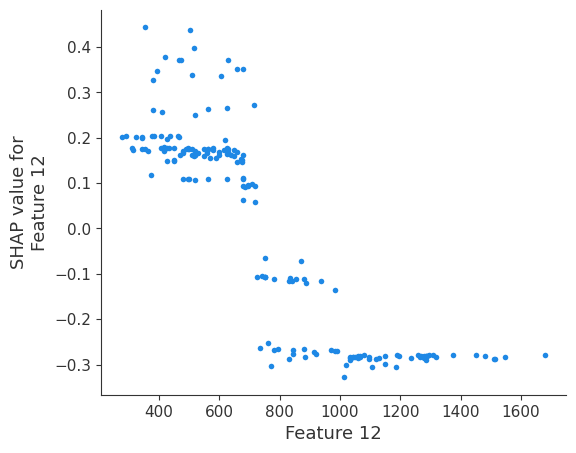

In [4]:
import io

import matplotlib.pyplot as pl


experiment = pipeline.experiment

for i in range(reg.n_features_in_):
    feature_name = f"feature {i}"
    experiment.log_feature(name=feature_name, tags=[feature_name])

    shap.dependence_plot(i, shap_values, X, interaction_index=None, show=False)

    fig = pl.gcf()
    buf = io.BytesIO()
    fig.savefig(buf, format="png")
    buf.seek(0)

    experiment.log_artifact(
        data_bytes=buf.read(), name=feature_name, tags=[feature_name],
    )

    buf.close()

## Retrieving your logged plot and features programmatically

Finally, we can retrieve a feature and its associated artifact plot using the `name` argument. We'll retrieve each artifact based on the names of the features logged. With `IO` and `PIL`, after retrieving the PNG byte representation of the plot, the plot can be rendered as a PNG image. 

feature 0


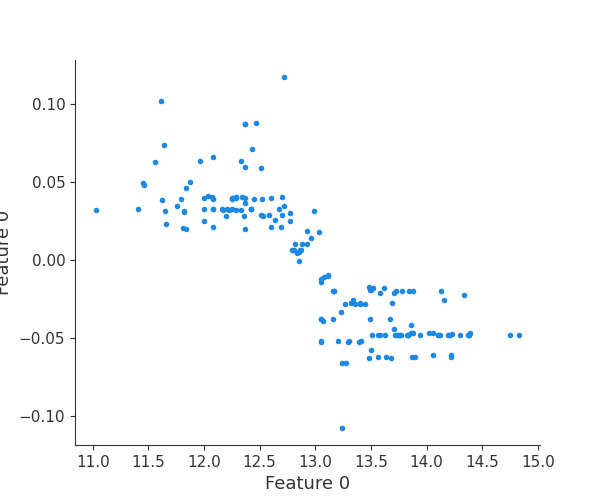

feature 1


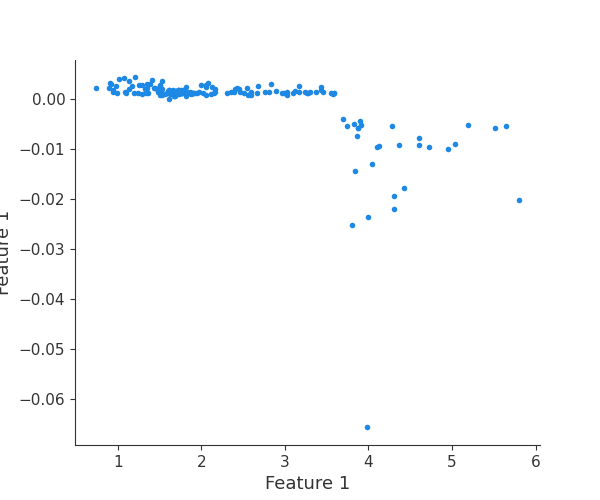

feature 2


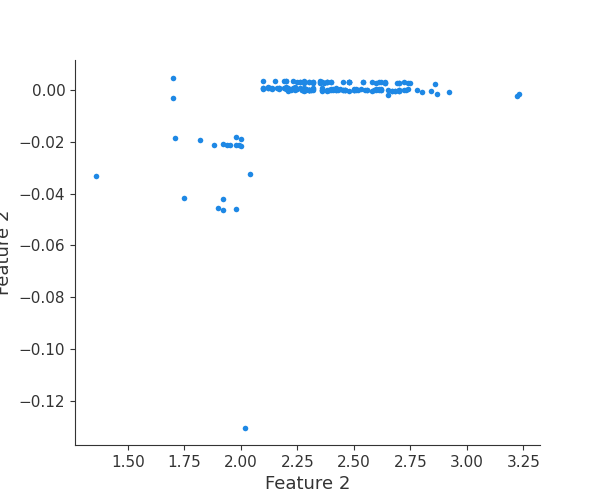

feature 3


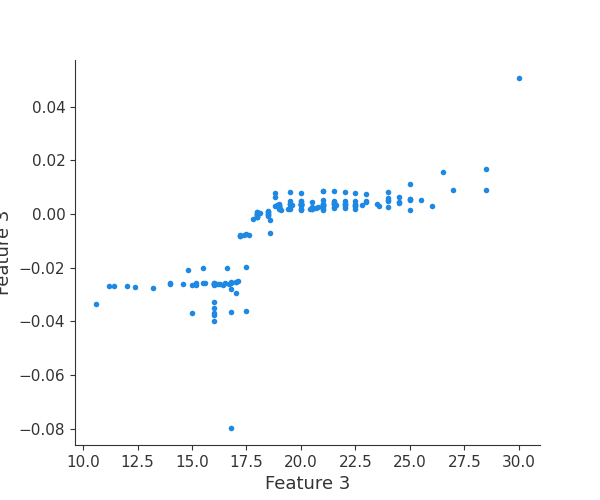

feature 4


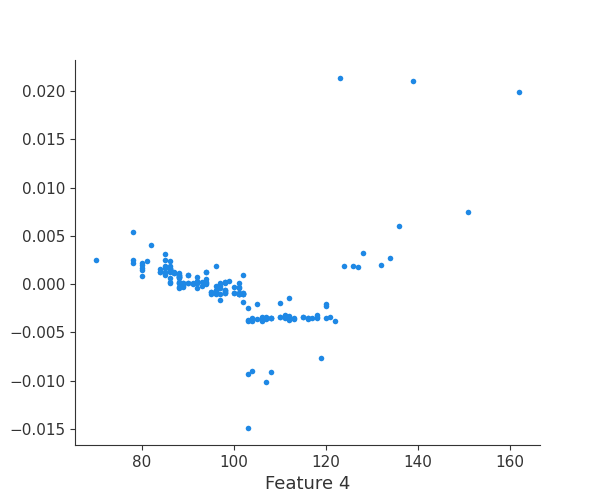

feature 5


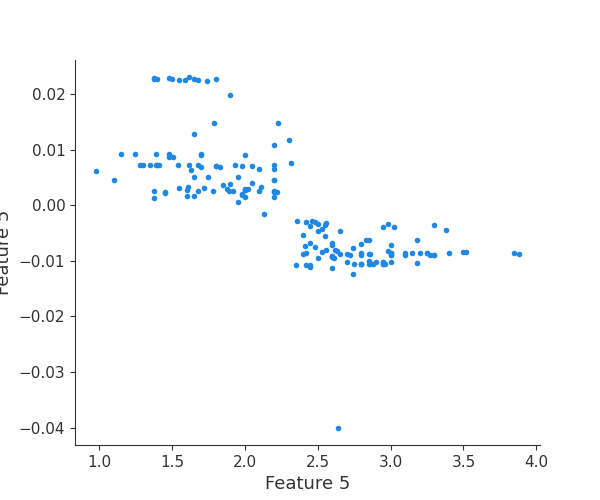

feature 6


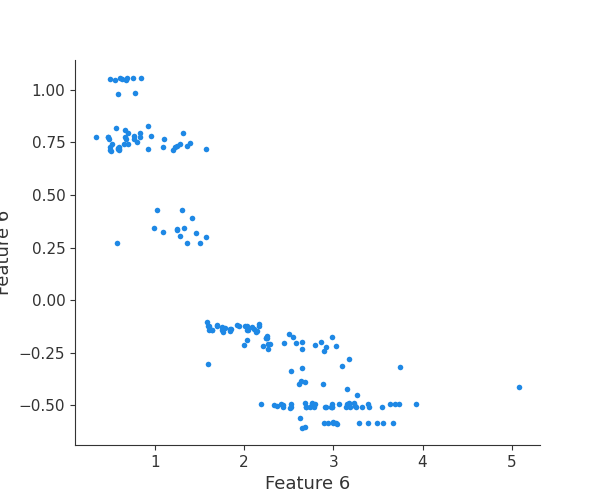

feature 7


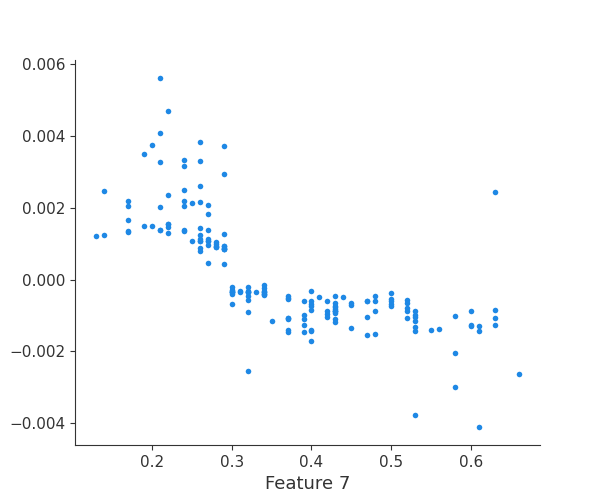

feature 8


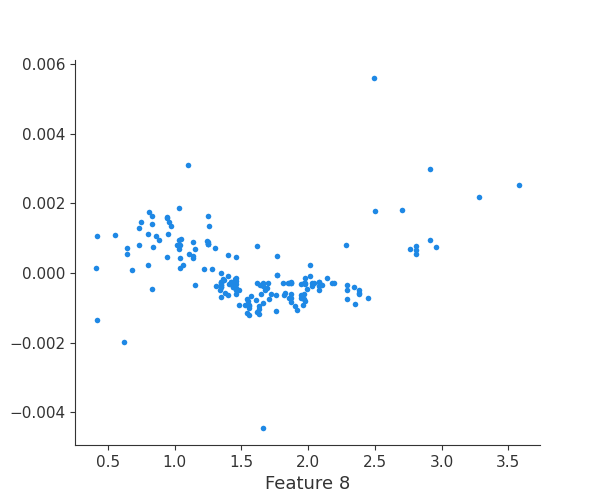

feature 9


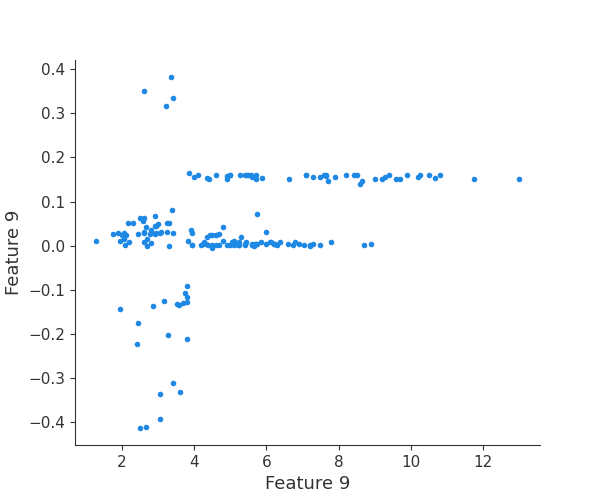

feature 10


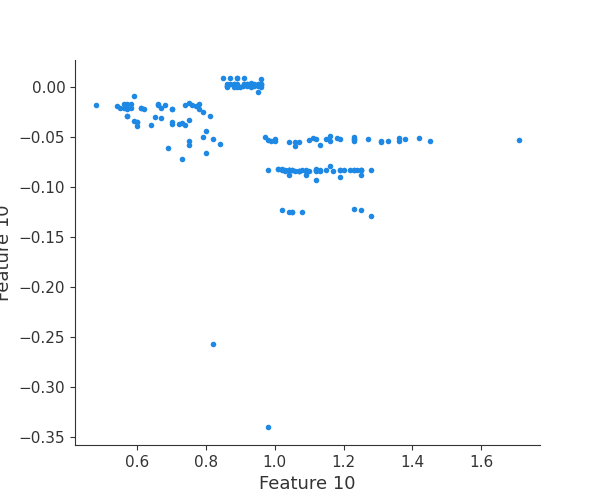

feature 11


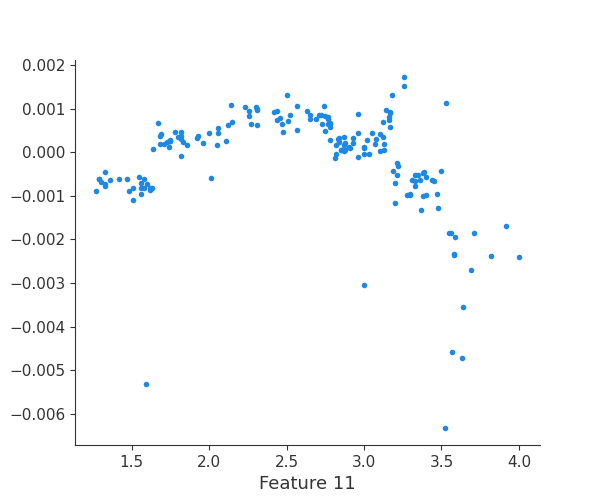

feature 12


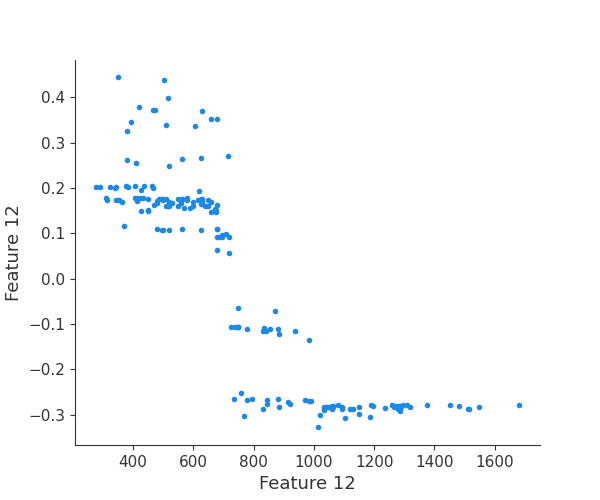

In [5]:
import io

from PIL import Image


experiment = pipeline.experiment

for feature in experiment.features():
    artifact = experiment.artifact(name=feature.name)

    buf = io.BytesIO(artifact.data)
    scatter_plot_image = Image.open(buf)

    print(feature.name)
    display(scatter_plot_image)